<a href="https://colab.research.google.com/github/guillemsmk/AB---Applied-Machine-Learning/blob/main/training/EntrenamientoDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Entrenamiento del modelo de detección de mascarillas**

Este notebook documenta el proceso de entrenamiento, evaluación y exportación
de un modelo de Deep Learning para clasificar imágenes faciales según el uso
o no de mascarilla.

El objetivo es analizar no solo el rendimiento del modelo, sino también
sus limitaciones y los casos en los que falla.


# **Setup Inicial**

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os, json, random

print("TF:", tf.__version__)


TF: 2.19.0


# **Descomprimimos ZIP**

In [ ]:
!ls -lah
!unzip -q archive.zip -d /content
!ls -lah "/content/Face Mask Dataset"


total 331M
drwxr-xr-x 1 root root 4.0K Jan 16 11:50 .
drwxr-xr-x 1 root root 4.0K Jan 16 11:47 ..
-rw-r--r-- 1 root root 331M Jan 16 11:54 archive.zip
drwxr-xr-x 4 root root 4.0K Dec  9 14:41 .config
drwxr-xr-x 1 root root 4.0K Dec  9 14:42 sample_data
total 20K
drwxr-xr-x 5 root root 4.0K Jan 16 11:54 .
drwxr-xr-x 1 root root 4.0K Jan 16 11:54 ..
drwxr-xr-x 4 root root 4.0K Jan 16 11:54 Test
drwxr-xr-x 4 root root 4.0K Jan 16 11:54 Train
drwxr-xr-x 4 root root 4.0K Jan 16 11:54 Validation


# **Definimos rutas y parámetros**

In [ ]:
DATA_ROOT = "/content/Face Mask Dataset"

TRAIN_DIR = os.path.join(DATA_ROOT, "Train")
VAL_DIR   = os.path.join(DATA_ROOT, "Validation")
TEST_DIR  = os.path.join(DATA_ROOT, "Test")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

CLASS_NAMES = ["WithMask", "WithoutMask"]


# **Cargamos dataset con image_dataset_from_directory**

El dataset se carga desde una estructura de directorios organizada por clases
y se divide en conjuntos de entrenamiento, validación y test para evaluar
correctamente la capacidad de generalización del modelo.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    labels="inferred",
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Class names (TF):", train_ds.class_names)


Found 10000 files belonging to 2 classes.
Found 800 files belonging to 2 classes.
Found 992 files belonging to 2 classes.
Class names (TF): ['WithMask', 'WithoutMask']


# **Optimizamos Pipeline**

In [ ]:
class_names = ["WithMask", "WithoutMask"]
print("class_names:", class_names)


class_names: ['WithMask', 'WithoutMask']


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)


# **EDA Visual en gráficas**

Se realiza una inspección visual del dataset para verificar la calidad de las imágenes,
la correcta asignación de etiquetas y detectar posibles dificultades que puedan afectar
al rendimiento del modelo.


## Muestra de imágenes + labels

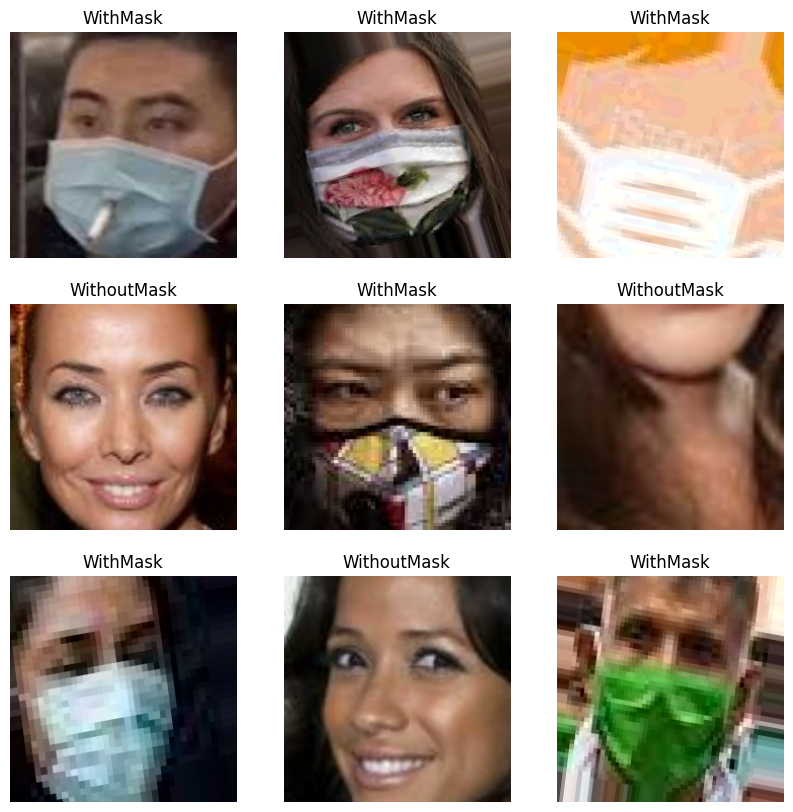

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        cls = np.argmax(labels[i].numpy())
        plt.title(class_names[cls])
        plt.axis("off")
plt.show()


## Distribución de clases

In [ ]:
import glob

def count_images(folder):
    return len(glob.glob(os.path.join(folder, "*.png"))) + len(glob.glob(os.path.join(folder, "*.jpg"))) + len(glob.glob(os.path.join(folder, "*.jpeg")))

counts = {}
for split_name, split_dir in [("Train", TRAIN_DIR), ("Validation", VAL_DIR), ("Test", TEST_DIR)]:
    counts[split_name] = {}
    for cls in ["WithMask", "WithoutMask"]:
        counts[split_name][cls] = count_images(os.path.join(split_dir, cls))

counts


{'Train': {'WithMask': 5000, 'WithoutMask': 5000},
 'Validation': {'WithMask': 400, 'WithoutMask': 400},
 'Test': {'WithMask': 483, 'WithoutMask': 509}}

## Plot Bar

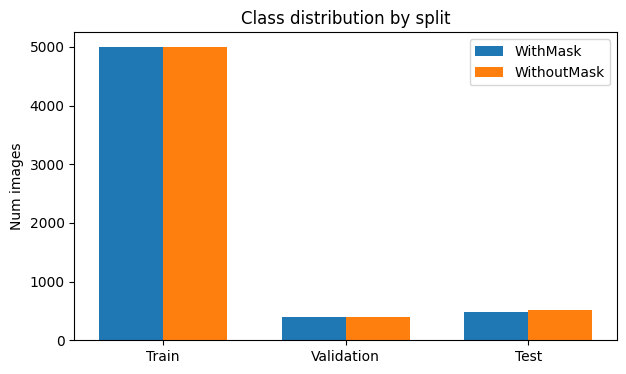

In [ ]:
splits = list(counts.keys())
withmask = [counts[s]["WithMask"] for s in splits]
withoutmask = [counts[s]["WithoutMask"] for s in splits]

x = np.arange(len(splits))
width = 0.35
plt.figure(figsize=(7,4))
plt.bar(x - width/2, withmask, width, label="WithMask")
plt.bar(x + width/2, withoutmask, width, label="WithoutMask")
plt.xticks(x, splits)
plt.ylabel("Num images")
plt.title("Class distribution by split")
plt.legend()
plt.show()


# **Aumentamos datos y preprocesamos**

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
], name="augmentation")

preprocess_layer = layers.Lambda(lambda x: preprocess_input(x), name="mobilenet_preprocess")


# **Modelo (MobileNETV2)**
## Definición del modelo y Transfer Learning

Se utiliza Transfer Learning con MobileNetV2 preentrenado en ImageNet como extractor
de características, permitiendo obtener buen rendimiento con un dataset de tamaño moderado.


In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = preprocess_layer(x)

x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(2, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_preprocess (Lambda)   │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# **Entrenamos al modelo**
## Estrategia de entrenamiento

Se emplean callbacks para controlar el proceso de entrenamiento, evitando el sobreajuste
y ajustando dinámicamente la tasa de aprendizaje cuando la validación se estanca.

In [ ]:
# Añadimos un early stopping

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=4,
    callbacks=callbacks
)


Epoch 1/4
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 69ms/step - accuracy: 0.9342 - loss: 0.1360 - val_accuracy: 0.9962 - val_loss: 0.0100 - learning_rate: 0.0010
Epoch 2/4
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - accuracy: 0.9944 - loss: 0.0179 - val_accuracy: 0.9962 - val_loss: 0.0072 - learning_rate: 0.0010
Epoch 3/4
313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 63ms/step - accuracy: 0.9961 - loss: 0.0108 - val_accuracy: 0.9975 - val_loss: 0.0080 - learning_rate: 0.0010
Epoch 4/4
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.9963 - loss: 0.0104 - val_accuracy: 0.9987 - val_loss: 0.0036 - learning_rate: 0.0010


# **Fine-tuning del modelo**

Se realiza un ajuste fino descongelando parcialmente el modelo base para adaptar
las características aprendidas a las particularidades del dataset.

In [ ]:
base_model.trainable = True

# Congelamos la mayor parte y afinamos solo el final
fine_tune_at = int(len(base_model.layers) * 0.7)
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    callbacks=callbacks
)


Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 104ms/step - accuracy: 0.9573 - loss: 0.1300 - val_accuracy: 0.9887 - val_loss: 0.0486 - learning_rate: 1.0000e-04
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 96ms/step - accuracy: 0.9974 - loss: 0.0091 - val_accuracy: 0.9825 - val_loss: 0.0670 - learning_rate: 1.0000e-04
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 100ms/step - accuracy: 0.9988 - loss: 0.0039 - val_accuracy: 1.0000 - val_loss: 4.6404e-05 - learning_rate: 1.0000e-04


# **Evaluación en Test y Matriz de Confusión**

Más allá de las métricas globales, se analizan los errores del modelo para comprender
en qué situaciones falla y cuáles son sus principales limitaciones.


In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy:", test_acc)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9991 - loss: 0.0028
Test accuracy: 0.9979838728904724


In [ ]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=2).numpy()
cm


array([[483,   0],
       [  2, 507]], dtype=int32)

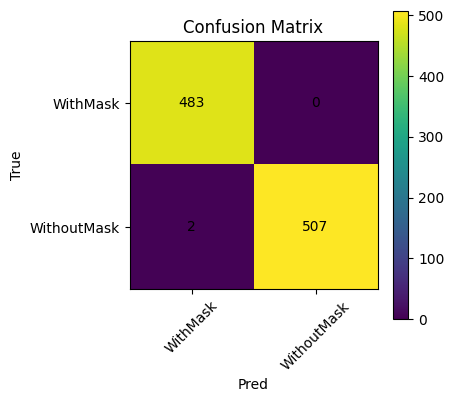

In [ ]:
plt.figure(figsize=(4,4))
plt.imshow(cm)
plt.xticks([0,1], class_names, rotation=45)
plt.yticks([0,1], class_names)
plt.title("Confusion Matrix")
plt.colorbar()
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha="center", va="center")
plt.ylabel("True")
plt.xlabel("Pred")
plt.show()


# **Análisis de errores**

Misclassified: 2 / 992


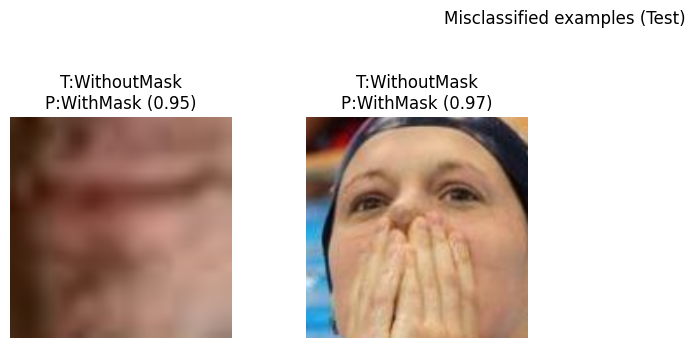

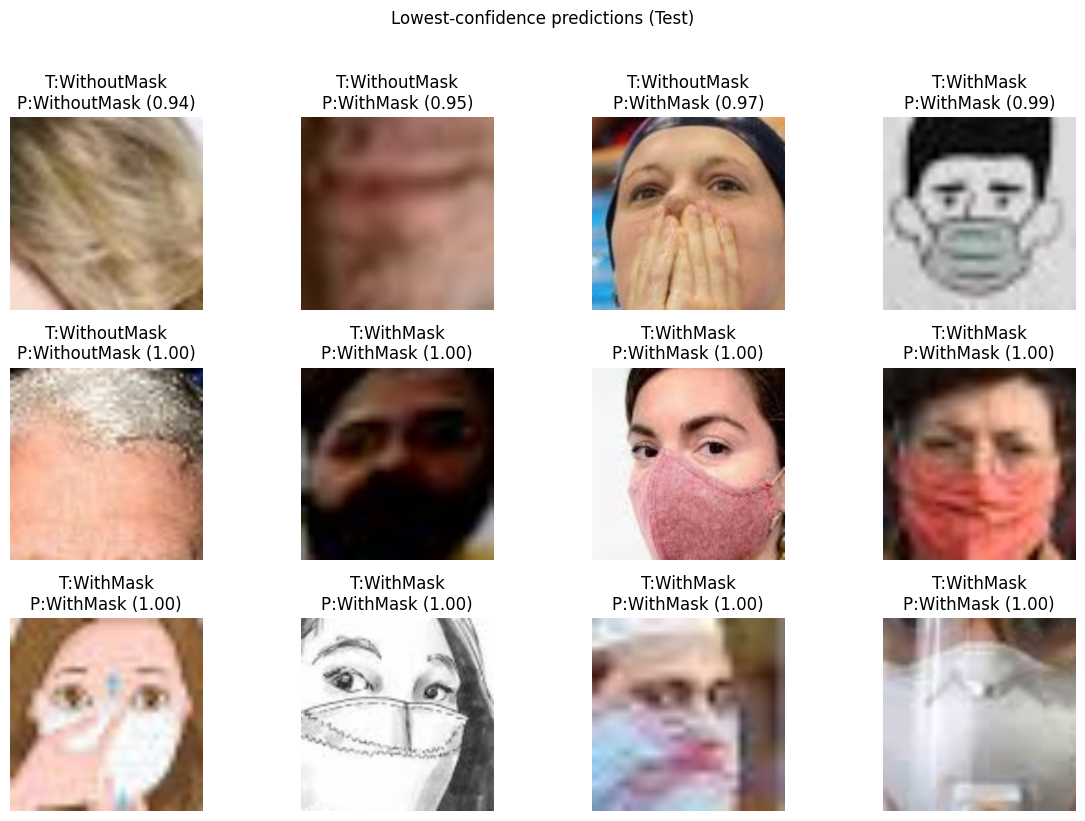

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class_names = ["WithMask", "WithoutMask"]

# 1) Recoger predicciones en test
y_true = []
y_pred = []
y_prob = []
x_images = []

for images, labels in test_ds:
    probs = model.predict(images, verbose=0)
    true = np.argmax(labels.numpy(), axis=1)
    pred = np.argmax(probs, axis=1)
    conf = np.max(probs, axis=1)

    y_true.extend(true)
    y_pred.extend(pred)
    y_prob.extend(conf)

    # Guardamos imágenes solo para inspección
    x_images.extend(images.numpy().astype("uint8"))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)
x_images = np.array(x_images)

# 2) Índices de errores
wrong_idx = np.where(y_true != y_pred)[0]
print(f"Misclassified: {len(wrong_idx)} / {len(y_true)}")

# 3) Mostrar hasta 12 errores
n_show = min(12, len(wrong_idx))
if n_show > 0:
    plt.figure(figsize=(12, 8))
    for i in range(n_show):
        idx = wrong_idx[i]
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(x_images[idx])
        plt.title(
            f"T:{class_names[y_true[idx]]}\nP:{class_names[y_pred[idx]]} ({y_prob[idx]:.2f})"
        )
        plt.axis("off")
    plt.suptitle("Misclassified examples (Test)", y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("No misclassifications found in the current test evaluation. 🎉")

# 4) Casos de baja confianza
low_conf_idx = np.argsort(y_prob)[:12]  # 12 más “dudosos”
plt.figure(figsize=(12, 8))
for i, idx in enumerate(low_conf_idx):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(x_images[idx])
    plt.title(
        f"T:{class_names[y_true[idx]]}\nP:{class_names[y_pred[idx]]} ({y_prob[idx]:.2f})"
    )
    plt.axis("off")
plt.suptitle("Lowest-confidence predictions (Test)", y=1.02)
plt.tight_layout()
plt.show()


# **Ajustamos modelo para exportación**


El modelo se prepara para inferencia y se exporta a TensorFlow.js para su integración
en la aplicación web, separando claramente entrenamiento e inferencia.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

IMG_SIZE = (224, 224)

# 1) Reconstruimos el MISMO backbone
base_infer = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)
base_infer.trainable = False

# 2) Modelo SOLO inferencia (sin data_augmentation)
inputs = layers.Input(shape=IMG_SIZE + (3,), dtype=tf.float32, name="image")
x = layers.Lambda(lambda t: preprocess_input(t), name="mobilenet_preprocess")(inputs)
x = base_infer(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(2, activation="softmax", name="pred")(x)

infer_model = tf.keras.Model(inputs, outputs, name="mask_detector_infer")

# 3) Copiamos pesos desde el modelo entrenado:
infer_model.set_weights(model.get_weights())

infer_model.summary()


Model: "mask_detector_infer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_preprocess (Lambda)   │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pred (Dense)                    │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# **Guardamos el modelo ajustado y lo necesario para la app**

In [ ]:
import os, json

EXPORT_DIR = "/content/exports"
os.makedirs(EXPORT_DIR, exist_ok=True)

saved_model_path = os.path.join(EXPORT_DIR, "saved_model_infer")
infer_model.export(saved_model_path)

class_names = ["WithMask", "WithoutMask"]
labels_path = os.path.join(EXPORT_DIR, "labels.json")
with open(labels_path, "w") as f:
    json.dump(class_names, f)

print("SavedModel (infer) at:", saved_model_path)
print("Labels at:", labels_path)


Saved artifact at '/content/exports/saved_model_infer'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='image')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  135574363386896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135574363387088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135574363384976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135574363373840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135574363389776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135574363387472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135574363388240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135574363387856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135574363388432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135574363385168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135

# **Convertimos a TensorFlowJS**

In [ ]:
!pip -q install tensorflowjs


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.5.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.40.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
xarray 2025.12.0 requires packaging>=24.1, but you have packaging 23.2 which is incompatible.


In [ ]:
TFJS_DIR = "/content/exports/tfjs_model"
!rm -rf "{TFJS_DIR}"

!tensorflowjs_converter \
  --input_format=tf_saved_model \
  "/content/exports/saved_model_infer" \
  "{TFJS_DIR}"

!ls -lah "{TFJS_DIR}"


2026-01-16 12:16:38.451296: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768565798.545429    8427 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768565798.572976    8427 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768565798.631961    8427 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768565798.632010    8427 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768565798.632019    8427 computation_placer.cc:177] computation placer alr

# **Exportamos los archivos necesarios para crear la app**

In [ ]:
!rm -f deploy_artifacts.zip
!zip -j deploy_artifacts.zip \
  /content/exports/tfjs_model/model.json \
  /content/exports/tfjs_model/group1-shard*.bin \
  /content/exports/labels.json

!ls -lah deploy_artifacts.zip


  adding: model.json (deflated 96%)
  adding: group1-shard1of3.bin (deflated 7%)
  adding: group1-shard2of3.bin (deflated 7%)
  adding: group1-shard3of3.bin (deflated 7%)
  adding: labels.json (deflated 19%)
-rw-r--r-- 1 root root 7.9M Jan 16 12:21 deploy_artifacts.zip
